The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.The MNIST database is a large database of handwritten digits that is commonly used for training various image processing systems.



In [48]:
#necessary libraries
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.special import softmax
import math
import tensorflow as tf
from tensorflow import keras

In [49]:
#ReLu function
def relu(X):
   return np.maximum(0,X)

#softmax function
def soft_max(X):
    m = softmax(X, axis=1)
    return m

#relu derivative
def Relu_deriv(x):
        o=relu(x)
        o[o>0]=1
        return o

$\frac{width input - kernel size + 2* padding}{stride} + 1 = width output $

we require width input = width output ,so padding=

$padding = \frac{stride(width input-1) + kernel - width input}{2}$

In [50]:
def small_conv(slice,filter):
    # Element-wise product of slice and filter. 
    prod = np.multiply(slice,filter)
    # Sum over all entries of the volume prod.
    out = np.sum(prod)
    return out

In [51]:
#Implements the forward propagation for a convolution function

def conv_forward(Activation_prev, kernel ):

# Activation_prev = output of the previous layer (input to the convolution layer)
  
    (num_datapoints, W_prev, W_prev, num_Channels) = Activation_prev.shape
    
    (k, k, num_Channels, n_kernels) = kernel.shape
    
    stride = 1 #given 
    pad = 2 #calculated
    new_W = int((W_prev + 2*pad - k)/stride) + 1     # dimension of the CONVOLUTION LAYER output 
    
    # Initialize the volume Z with zeros.
    Z = np.zeros([num_datapoints, new_W, new_W, n_kernels])
    
    Activation_padded = np.pad(Activation_prev, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))

    
    for i in range(num_datapoints):                              
        x_pad = Activation_padded[i,:,:,:]   # padded activation of ith training sample
        for h in range(new_W):                          
            for w in range(new_W):                     
                for c in range(n_kernels):                 
                    
                    # corners of the current slice
                    ver_start = h*stride
                    ver_end = h*stride + k
                    hor_start = w*stride 
                    hor_end = w*stride + k
                    
                    # Use the corners to define the (3D) slice of x_pad 
                    x_slice = x_pad[ver_start:ver_end,hor_start:hor_end,:]
                    # Convolve the (3D) slice with the respective filter 
                    Z[i, h, w, c] = small_conv(x_slice, kernel[:, :, :, c])
                                        
    
    conv_output=relu(Z)
    # info =needed information for the conv_backward() function
    info= (Activation_prev, kernel ,Z)
    return conv_output,info

In [52]:
#Implements the backward propagation for a convolution function

def conv_backward(dC, infor):
    
#  dC = gradient of the error with respect to the output of the conv layer {array of shape (num_datapoints, new_W, new_W, n_kernels)}
#  infor= needed values for the conv_backward() got from conv_forward()
#  A_prev = input given to the convolution layer
# Z= convolution of A_prev and kernel (without relu function applied)
    
    (A_prev, kernel, Z) = infor  

    dC_wrt_dZ=Relu_deriv(Z)

    dZ= np.multiply( dC , dC_wrt_dZ)
# dZ= gradient of the error with respect to Z , {array of shape (num_datapoints, new_W, new_W, n_kernels)}
    
    (num_datapoints, W_prev, W_prev, num_Channels) = A_prev.shape
    (k, k, num_Channels, n_kernels) = kernel.shape

    stride = 1 # given
    pad = 2 # calculated
    
    (num_datapoints, new_W, new_W, n_kernels) = dZ.shape

# dA_prev= gradient of the error with respect to A_prev(input of convolution layer)    
# dker = gradient of the error with respect to kernel of convolution layer
    # Initialize dA_prev, dKer
    dA_prev = np.zeros((num_datapoints, W_prev, W_prev, num_Channels))                           
    dker = np.zeros((k, k, num_Channels, n_kernels))
  
    # Pad A_prev and dA_prev
    A_prev_padded = np.pad(A_prev, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
    dA_prev_padded =np.pad(dA_prev, ((0,0), (pad,pad), (pad,pad), (0,0)), 'constant', constant_values = (0,0))
 
    for i in range(num_datapoints):                 
        
        x_prev_pad = A_prev_padded[i]         #  ith training example from A_prev_pad 
        dx_prev_pad = dA_prev_padded[i]      #  ith training example from dA_prev_pad
        
        for h in range(new_W):                  
            for w in range(new_W):              
                for c in range(n_kernels):         
                    
                    # corners of the current slice
                    ver_start = h
                    ver_end = ver_start + k
                    hor_start = w
                    hor_end = hor_start + k
                    
                    # Use the corners to define the slice from x_prev_pad
                    x_slice = x_prev_pad[ver_start:ver_end, hor_start:hor_end, :]
                    
                    dx_prev_pad[ver_start:ver_end, hor_start:hor_end, :] += kernel[:,:,:,c] * dZ[i, h, w, c]
                    dker[:,:,:,c] += x_slice * dZ[i, h, w, c]
              
        # unpadding dx_prev_pad to get dA_prev of ith example
        dA_prev[i, :, :, :] = dx_prev_pad[pad:-pad, pad:-pad, :]
  
    return dA_prev, dker


In [53]:
# Implements the forward pass of the pooling layer

def pool_forward(Activation_prev ):
# Activation_prev= input of pooling layer (output of previous layer)

    (num_datapoints, W_prev, W_prev, num_Channels) = Activation_prev.shape
    pool_size = 2 # given
    stride = 2 #given
    
    # Define the dimensions of the output
    new_W = int(1 + (W_prev - pool_size) / stride)
    # Initialize output matrix 
    out_pool = np.zeros((num_datapoints, new_W, new_W, num_Channels))              
    
    for i in range(num_datapoints):                         
        for h in range(new_W):                     
            for w in range(new_W):                
                for c in range (num_Channels):            
                    
                    #corners of the current slice
                    ver_start = h*stride
                    ver_end = h*stride + pool_size
                    hor_start = w*stride
                    hor_end = w*stride + pool_size
                    
                    # Use the corners to define the current slice of the ith training example Activation_prev
                    a_slice = Activation_prev[i, ver_start:ver_end, hor_start:hor_end,c]
                    
                    # pooling operation on the slice
                    out_pool[i, h, w, c] = np.max(a_slice)
                            
    return out_pool

In [54]:
def max_mask(x):
#mask contains a True at the position corresponding to the max entry of x and contains false at other positions
    mask = x == np.max(x)
    return mask

In [55]:
#  Implements the backward pass of the pooling layer
def pool_backward(dPool, A_prev):
  
#dPool = gradient of error with respect to the output of the pooling layer
# A_prev = input of pooling layer      
#dA_prev = gradient of error with respect to the input of the pooling layer (same shape as A_prev)
    stride = 2 # given
    pool_size =2 #given
    
    num_datapoints, new_W, new_W, num_Channels = dPool.shape
    dA_prev = np.zeros(A_prev.shape)
    
    for i in range(num_datapoints):                     
        x = A_prev[i]          # ith training example from A_prev
        for h in range(new_W):                  
            for w in range(new_W):              
                for c in range(num_Channels):          
                    #corners of the current slice (array 2D)
                    ver_start = h
                    ver_end = ver_start + pool_size
                    hor_start = w
                    hor_end = hor_start + pool_size
                    
                    # Use the corners and c to define the current slice (array 2D) from x
                    x_slice = x[ver_start:ver_end, hor_start:hor_end, c]
                    # Create the mask from x_slice
                    mask = max_mask(x_slice)
                    # Set dA_prev to be dA_prev + (the mask multiplied by the correct entry of dPool) 
                    dA_prev[i, ver_start:ver_end, hor_start:hor_end, c] += np.multiply(mask, dPool[i, h, w, c])
          
    return dA_prev

In [56]:
# Flattening (unraveling) layer
def flat_forward( Prev_Act ):
# Prev_Act = output of previous pooling layer , (input to the  flattening layer)
   num_datapoints, new_W, new_W, num_Channels = Prev_Act.shape
   flatten_output= np.zeros((num_datapoints, (new_W*new_W*num_Channels)))
   
   for i in range(num_datapoints):                     
        act_map_volume = Prev_Act[i]          # ith training example from Prev_Act
        feature_vec=act_map_volume.flatten()
        flatten_output[i,:]=feature_vec
   
   return flatten_output

In [57]:
def flat_backpropagation(dF, Prev_Act):
   # Prev_Act = output of previous pooling layer , (input to the  flattening layer)
   # dF = gradient of error with respect to output of flattening layer
   # dPrev_Act = gradient of error with respect to input of flattening layer,(same shape as Prev_Act)
   dPrev_Act=dF.reshape(Prev_Act.shape)
   return dPrev_Act

In [58]:
def MLP_forward(feature_vec,W_hidden,b_hidden,W_out,b_out):
#feature_vec = output of flatten layer.(input to MLP)    
    Z_h = np.dot(feature_vec,W_hidden) + b_hidden
    activation_hidden = relu(Z_h)

    # Phase 2
    Z_o = np.dot(activation_hidden, W_out) + b_out
    y_pred = soft_max(Z_o)
    
    #information needed for backpropagation of MLP
    info_MLP=(feature_vec,W_hidden,b_hidden,Z_h,activation_hidden,W_out,b_out,Z_o,y_pred)
    return y_pred,info_MLP

In [59]:
def MLP_backward(y_label,info_MLP):
       #information for backpropagation of MLP got from MLP_forward()
       (feature_vec,W_hidden,b_hidden,Z_h,activation_hidden,W_out,b_out,Z_o,y_pred)=info_MLP
       
       dZ_o = y_pred - y_label
       dZ_o_wrt_W_out = activation_hidden

       dW_out = np.dot(dZ_o_wrt_W_out.T, dZ_o)
       db_out = dZ_o     

       dZ_o_wrt_act_hidden = W_out
       dactivation_hidden = np.dot(dZ_o , dZ_o_wrt_act_hidden.T)
       dact_hidden_wrt_Z_h = Relu_deriv(Z_h)
       dZ_h_wrt_W_hidden = feature_vec
       dW_hidden = np.dot(dZ_h_wrt_W_hidden.T, dact_hidden_wrt_Z_h * dactivation_hidden)
       db_hidden = dactivation_hidden * dact_hidden_wrt_Z_h    

       dZ_h_wrt_input= W_hidden   
       dinput=np.dot(dact_hidden_wrt_Z_h * dactivation_hidden , dZ_h_wrt_input.T)

       return dinput,dW_out,db_out,dW_hidden,db_hidden


In [60]:
def Vanilla_SGD(gradients,parameters):
      learn_rate=0.001
      (dkernel1 , dkernel2, dW_hidden , db_hidden , dW_out , db_out)=gradients
      (kernel1_old , kernel2_old , W_hidden_old , b_hidden_old, W_out_old , b_out_old )=parameters
      
      kernel1_new = kernel1_old - learn_rate* (dkernel1) 
      kernel2_new = kernel2_old - learn_rate* (dkernel2) 
      
      W_hidden_new = W_hidden_old - learn_rate* (dW_hidden) 
      b_hidden_new = b_hidden_old - learn_rate* (db_hidden) 
      
      W_out_new = W_out_old - learn_rate* (dW_out) 
      b_out_new = b_out_old - learn_rate* (db_out) 

      parameters=(kernel1_new ,kernel2_new ,W_hidden_new ,b_hidden_new , W_out_new , b_out_new)
        
      return parameters
      

In [61]:
def  Momentum(gradients,parameters,V):
          learn_rate=0.001
          alpha = 0.9
          (dkernel1 , dkernel2, dW_hidden , db_hidden , dW_out , db_out)=gradients
          (kernel1_old , kernel2_old , W_hidden_old , b_hidden_old, W_out_old , b_out_old )=parameters
          (V_kernel1 , V_kernel2, V_W_hidden , V_b_hidden , V_W_out , V_b_out) =V
          
          V_kernel1= alpha*V_kernel1 - learn_rate *(dkernel1)
          kernel1_new=kernel1_old + V_kernel1
          V_kernel2 = alpha*V_kernel2 - learn_rate* (dkernel2) 
          kernel2_new = kernel2_old + V_kernel2
      
          V_W_hidden = alpha*V_W_hidden - learn_rate* (dW_hidden) 
          W_hidden_new = W_hidden_old + V_W_hidden
          V_b_hidden = alpha*V_b_hidden - learn_rate* (db_hidden) 
          b_hidden_new = b_hidden_old + V_b_hidden
          
          V_W_out = alpha*V_W_out - learn_rate* (dW_out) 
          W_out_new = W_out_old + V_W_out
          V_b_out = alpha*V_b_out - learn_rate* (db_out) 
          b_out_new = b_out_old + V_b_out

          parameters=(kernel1_new ,kernel2_new ,W_hidden_new ,b_hidden_new , W_out_new , b_out_new)
          V_new=(V_kernel1 , V_kernel2, V_W_hidden , V_b_hidden , V_W_out , V_b_out) 
          return parameters,V_new
                

In [62]:
def RMSprop(gradients, parameters ,V):
          learn_rate=0.001
          beta = 0.9
          epsilon= 1e-07
          (dkernel1 , dkernel2, dW_hidden , db_hidden , dW_out , db_out)=gradients
          (kernel1_old , kernel2_old , W_hidden_old , b_hidden_old, W_out_old , b_out_old )=parameters
          (V_kernel1 , V_kernel2, V_W_hidden , V_b_hidden , V_W_out , V_b_out) =V
          
          V_kernel1= beta*V_kernel1 + (1-beta)*(dkernel1**2)
          V_kernel2 = beta*V_kernel2 + (1-beta)* (dkernel2**2) 
          V_W_hidden = beta*V_W_hidden + (1-beta)* (dW_hidden**2) 
          V_b_hidden = beta*V_b_hidden + (1-beta)* (db_hidden**2)         
          V_W_out = beta*V_W_out + (1-beta)* (dW_out**2) 
          V_b_out = beta*V_b_out + (1-beta)* (db_out**2) 
       
          kernel1_new = kernel1_old - learn_rate* (dkernel1 /np.sqrt(V_kernel1 + epsilon) ) 
          kernel2_new = kernel2_old - learn_rate* (dkernel2 /np.sqrt(V_kernel2+ epsilon)) 
          W_hidden_new = W_hidden_old - learn_rate* (dW_hidden / np.sqrt(V_W_hidden + epsilon)) 
          b_hidden_new = b_hidden_old - learn_rate* (db_hidden / np.sqrt(V_b_hidden + epsilon)) 
          W_out_new = W_out_old - learn_rate* (dW_out / np.sqrt(V_W_out + epsilon)) 
          b_out_new = b_out_old - learn_rate* (db_out / np.sqrt(V_b_out+ epsilon)) 

          parameters=(kernel1_new ,kernel2_new ,W_hidden_new ,b_hidden_new , W_out_new , b_out_new)
          V_new=(V_kernel1 , V_kernel2, V_W_hidden , V_b_hidden , V_W_out , V_b_out) 
          return parameters,V_new

In [63]:
#Cross Entropy Loss
def cross_entropy_god(targets,predictions,  epsilon=1e-19):
    """
    Computes cross entropy between targets (encoded as one-hot vectors) and predictions. 
    Input: predictions (Num_datapoints, num_classlabels) ndarray
           targets (Num_datapoints, num_classlabels) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions+1e-9))/N
    return ce

In [64]:
#only forward prpogation
def forward_path(data_points , current_parameters):
      (kernel1 ,kernel2 , weight_hidden ,bias_hidden, weight_out , bias_out) =  current_parameters   
      # forward propagation
      conv1 , bla = conv_forward(data_points, kernel1)
      maxpool1 = pool_forward(conv1)
                
      conv2 , bla = conv_forward(maxpool1 , kernel2 )
      maxpool2 = pool_forward( conv2)
                
      flatten_feature = flat_forward(maxpool2)
      prediction, bla = MLP_forward(flatten_feature , weight_hidden ,bias_hidden , weight_out ,bias_out)
      
      return  prediction

In [65]:

def tsne_plotting (feature_vec ,labels , string):
       colorss=['blue', 'black', 'red', 'green', 'yellow', 'cyan','orange','brown','violet','grey']
       z = TSNE(n_components=2, verbose=1, random_state=123).fit_transform(feature_vec)
       class_co = np.array( tf.argmax(labels, axis=1) )
       plt.figure()
       for i in range(labels.shape[0]):
          plt.plot(z[i][0], z[i][1], marker="o", markersize=5, color= colorss[class_co[i]])
       
       plt.title("t-sne plot at the end of epoch = "+ string)
       plt.show()


In [66]:
def encode_labels(data_labels, num_classes):
        #Encode labels into a one-hot representation
        onehot = np.zeros((data_labels.shape[0],num_classes))
        for i in range(data_labels.shape[0]):
            onehot[i,data_labels[i]] = 1.0
        return onehot

In [67]:
def Complete_model(SGD_variant ,train_images , train_labels,num_epoch=15 ):
       
       #Initialisation:
       num_input_MLP=(196)
       num_hidden_MLP=49
       num_out_MLP=10
       parameter_SGD_variant=(0,0,0,0,0,0)   

       kernel1= np.random.randn(5, 5, 1, 4)
       kernel2= np.random.randn(5, 5, 4, 4)
       weight_hidden= np.random.rand(num_input_MLP,num_hidden_MLP)
       bias_hidden = np.random.randn(num_hidden_MLP)
       weight_out = np.random.rand(num_hidden_MLP,num_out_MLP)
       bias_out = np.random.randn(num_out_MLP)
       
       train_error=  [0] * (num_epoch)  # stores the cross entropy train error at the end of each epoch
       test_error =  [0] * (num_epoch)   # stores the cross entropy test error at the end of each epoch
       accuracy =  [0] * (num_epoch)  # stores the validate accuracy at the end of each epoch

       # forward propagation
       conv1 , info_convback1 = conv_forward(train_images , kernel1)
       maxpool1 = pool_forward(conv1)
                
       conv2 , info_convback2 = conv_forward(maxpool1 , kernel2 )
       maxpool2 = pool_forward( conv2)
                
       flatten_feature = flat_forward(maxpool2)
       y_train_prediction,info_MLP_back = MLP_forward(flatten_feature , weight_hidden ,bias_hidden , weight_out ,bias_out)

       for ep in range(num_epoch ):

                #backward propagation
                grad_flatten,grad_Wout,grad_bout,grad_Whid,grad_bhid = MLP_backward(train_labels,info_MLP_back)
                grad_pool2 = flat_backpropagation(grad_flatten, maxpool2)
                
                grad_conv2 = pool_backward(grad_pool2 , conv2)
                grad_pool1, grad_ker2 =conv_backward(grad_conv2 , info_convback2)

                grad_conv1 =pool_backward(grad_pool1 , conv1)
                d_input , grad_ker1 =conv_backward(grad_conv1 , info_convback1)

                # current parameters
                all_gradient = (grad_ker1 ,grad_ker2 ,grad_Whid ,grad_bhid ,grad_Wout ,grad_bout )
                all_parameter = (kernel1 ,kernel2 , weight_hidden ,bias_hidden, weight_out , bias_out)

                
                #weight updation
                if (SGD_variant == "Vanilla_SGD"):
                    all_parameter_updated = Vanilla_SGD(all_gradient , all_parameter) 
                elif(SGD_variant == "Momentum"):
                    all_parameter_updated , parameter_SGD_variant =Momentum(all_gradient ,all_parameter ,parameter_SGD_variant)
                elif(SGD_variant == "RMSprop"):
                    all_parameter_updated , parameter_SGD_variant =RMSprop(all_gradient ,all_parameter ,parameter_SGD_variant)     

                (kernel1 ,kernel2 , weight_hidden ,bias_hidden, weight_out , bias_out)=all_parameter_updated     
                
                # forward propagation
                conv1 , info_convback1 = conv_forward(train_images , kernel1)
                maxpool1 = pool_forward(conv1)
                
                conv2 , info_convback2 = conv_forward(maxpool1 , kernel2 )
                maxpool2 = pool_forward( conv2)
                
                flatten_feature = flat_forward(maxpool2)
                y_train_prediction,info_MLP_back = MLP_forward(flatten_feature , weight_hidden ,bias_hidden , weight_out ,bias_out)
                
                train_error[ep]= cross_entropy_god(train_labels , y_train_prediction)
                
                
                 # Shuffle the training data
                
                permutation = np.random.permutation(len(train_images))
                train_images = train_images[permutation]
                train_labels = train_labels[permutation] 
                
               
       #printing the requied   
       epoch_list=np.array(range(1,num_epoch+1))
       plt.figure() 
       plt.plot( epoch_list,train_error )
       plt.xlabel('number of epochs completed')
       plt.ylabel('train error')
       plt.title('train error with each epoch')
       plt.show()

       return all_parameter_updated     

In [68]:

(train_images_data, train_labels_data), (test_images_data, test_labels_data) = tf.keras.datasets.mnist.load_data()


Using 100 images per class for the training set i.e., use 1000 images for training.

In [ ]:
train_dictionary ={i:[] for i in range(10)}
for img,label in zip(train_images_data,train_labels_data):
  train_dictionary[label].append(np.array(img).reshape(28,28,1))

traindata=[]
trainlab=[]
for i in range(10):
  traindata.append(np.array(train_dictionary[i][:100]))
  trainlab.append([i]*100)

train_images=np.array(traindata).reshape(1000,28,28,1)  
train_labels=np.array(trainlab).reshape(1000,1)

In [70]:
test_dictionary ={i:[] for i in range(10)}
for img,label in zip(test_images_data,test_labels_data):
  test_dictionary[label].append(np.array(img).reshape(28,28,1))

testdata=[]
testlab=[]
for i in range(10):
  testdata.append(np.array(test_dictionary[i][:100]))
  testlab.append([i]*100)

test_images=np.array(testdata).reshape(1000,28,28,1)  
test_labels=np.array(testlab).reshape(1000,1)

In [71]:
train_labels=encode_labels(train_labels,10)
test_labels=encode_labels(test_labels,10)

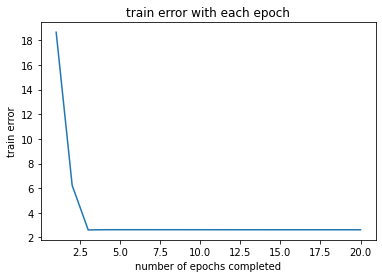

In [72]:
train_images_copy= train_images
train_labels_copy= train_labels

all_parameters=Complete_model( "Momentum" , train_images_copy ,train_labels_copy ,20)


In [88]:
test_images_prediction= forward_path(test_images,all_parameters) 

Actual label= [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
model predicted label= [ True False False False False False False False False False]


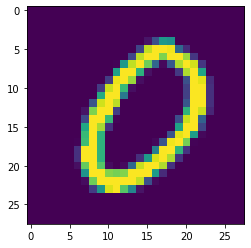

In [103]:
img_data_point=test_images[69].reshape(28,28)
plt.imshow(img_data_point)
print("Actual label=", (test_labels[69]))
print("model predicted label=",max_mask(test_images_prediction[69]) )
